# 10. 회귀모형 평가

In [2]:
library(bayesrules)
library(tidyverse)
library(bayesplot)
library(rstanarm)

In [ ]:
bike_model <- stan_glm(formula = rides ~ temp_feel, 
                       data = bikes,
                       family = gaussian, # 관측값의 정규분포 가정
                       prior_intercept = normal(5000, 1000), # 절편에 대한 사전분포
                       prior = normal(100, 40), # 회귀계수에 대한 사전분포
                       prior_aux = exponential(0.0008), # 관측값 분산에 대한 사전분포
                       chains = 4, iter = 5000*2, seed = 84735)

In [6]:
bike_model_df <- as.data.frame(bike_model)

<br>

## 10.01. 모형의 공정성 평가

$$\begin{split}
Y_i | \beta_0, \beta_1, \sigma & \stackrel{ind}{\sim} N\left(\mu_i, \sigma^2\right) \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_i \\
\beta_{0c}  & \sim N\left(5000, 1000^2 \right)  \\
\beta_1  & \sim N\left(100, 40^2 \right) \\
\sigma   & \sim \text{Exp}(0.0008)  .\\
\end{split}$$

### 해당 정규회귀모형에 대하여, 아래의 4가지를 고려

<br>

1. 데이터는 어떻게 수집되었는가?

2. 데이터는 누구에 의해, 어떤 목적으로 수집되었는가?

3. 분석 결과나 데이터 수집 자체가, 개인과 사회에 어떤 영향을 미칠 수 있는가?

4. 이 분석에는 어떤 편향이 포함될 수 있는가?

<br>

## 10.02. 모형이 얼마나 잘못되었는가?

<br>

### 모형의 가정에 대한 확인

#### 위의 정규회귀모형은 아래와 같은 가정을 가짐

> 1. 데이터의 구조
>
>  $N$개의 관측값 쌍 $\left\lbrace (Y_1,X_1), (Y_2,X_2),...,(Y_n,X_n) \right\rbrace$에서, $i$번째 관측값 $Y_I$은 $j$번째 관측값 $Y_j$와 독립
>

> 2. 변수간의 관계 (선형성)
>
>  $Y$가 $X$가 선형관계라면,  $\mu_i = \beta_0 + \beta_1 X_i$
>

> 3. 변동성
>
>  모든 $X$에 대해서 $Y$는, $\mu$와 표준편차 $\sigma$를 가지는 정규분포를 따름 
>
>  $Y_i | \mu,\sigma \sim N(\mu, \sigma^2)$

$$Y_i | \beta_0, \beta_1, \sigma \stackrel{ind}{\sim} N(\mu_i, \sigma^2) \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1 X_i  .$$

`geom_smooth()` using formula = 'y ~ x'


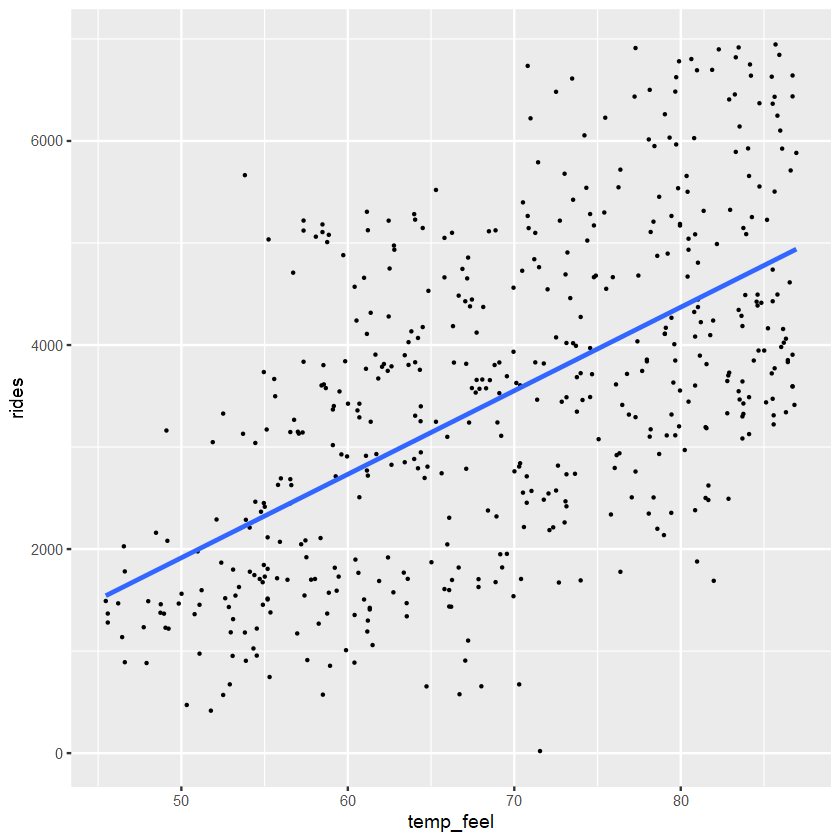

In [3]:
ggplot(bikes, aes(y = rides, x = temp_feel)) + 
  geom_point(size = 0.2) + 
  geom_smooth(method = "lm", se = FALSE)

<br>

### 사후예측분포 검사

<br>

#### `posterior_predict(model, newdata)` : 각 마르코프 체인 값 별로, 모든 관측값에 대하여 예측값 생성

In [23]:
set.seed(84735)
predictions <- posterior_predict(bike_model, newdata = bikes)

In [25]:
predictions %>% dim

[1] 20000   500

> $N$개의 각 마르코프 체인 값 ($j \in \{1,2,...,N\}$) 별로,  모든 관측값에 대하여 예측 시뮬레이션


$$\begin{array}{lll}
\text{Markov chain parameter sets} & & \text{Simulated samples} \\
\left[
\begin{array}{lll} 
\beta_0^{(1)} & \beta_1^{(1)} & \sigma^{(1)} \\
\hline
\beta_0^{(2)} & \beta_1^{(2)} & \sigma^{(2)} \\
\hline
\vdots & \vdots & \vdots \\
\hline
\beta_0^{(20000)} & \beta_1^{(20000)} & \sigma^{(20000)} \\
\end{array}
\right]
& \; \longrightarrow \;
& \left[
\begin{array}{llll} 
Y_1^{(1)} & Y_2^{(1)} & \cdots & Y_{500}^{(1)} \\
\hline
Y_1^{(2)} & Y_2^{(2)} & \cdots & Y_{500}^{(2)} \\
\hline
\vdots & \vdots &  & \vdots \\
\hline
Y_1^{(20000)} & Y_2^{(20000)} & \cdots & Y_{500}^{(20000)} \\
\end{array}
\right]
\end{array}$$

> $N$개의 관측값에 대한 예측 시뮬레이션 결과를 통하여 
> 
> 마르코프 체인의 각 값에 의한 예측분포가, 실제 관측값 분포가 가진 중심성과 특성 등을 잘 반영하는지 확인 

<br>

- 1번째 마르코프 체인 값에 통하여, 500개의 관측값에 대하여 시뮬레이션

In [7]:
first_set <- head(bike_model_df, 1)
first_set

,(Intercept),temp_feel,sigma
,<dbl>,<dbl>,<dbl>
1,-2593.578,87.59029,1362.773


In [9]:
beta_0 <- first_set$`(Intercept)`
beta_1 <- first_set$temp_feel
sigma  <- first_set$sigma

set.seed(84735)
one_simulation <- bikes %>% 
  mutate(mu = beta_0 + beta_1 * temp_feel,
         simulated_rides = rnorm(500, mean = mu, sd = sigma)) %>% 
  select(temp_feel, rides, simulated_rides)

In [10]:
head(one_simulation, 2)

,temp_feel,rides,simulated_rides
,<dbl>,<int>,<dbl>
1,64.72625,654,3985.100
2,49.04645,1229,1533.649


<br>

- 시뮬레이션 데이터가, 실제 관측값이 가진 중섬성과 특성을 가지고 있는지 확인

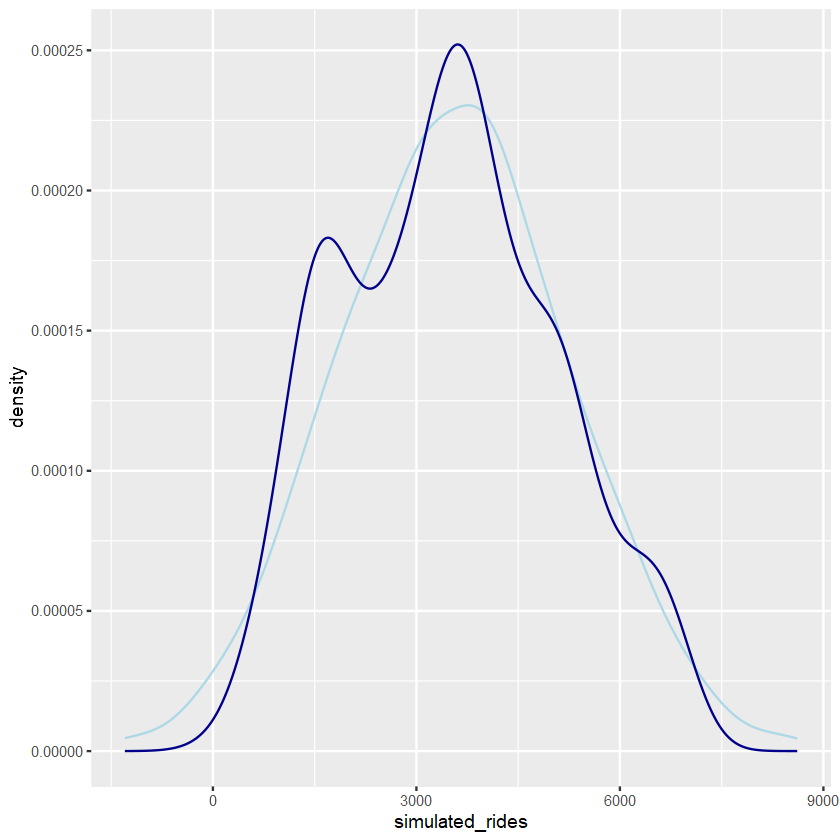

In [11]:
ggplot(one_simulation, aes(x = simulated_rides)) + 
  geom_density(color = "lightblue") + 
  geom_density(aes(x = rides), color = "darkblue")

<br>

* 50개의 마르코프 체인 값을 통한 시뮬레이션과, 실제 관측값을 비교

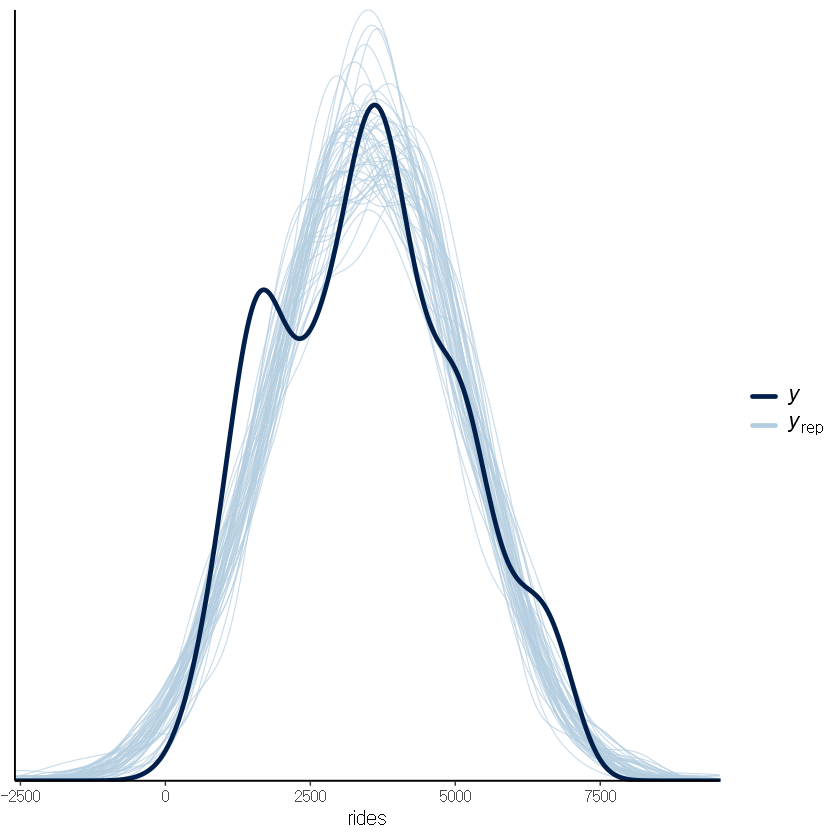

In [12]:
pp_check(bike_model, nreps = 50) + 
  xlab("rides")

<br>

### 잘못된 모형

<br>

#### $Y$와 $X$에 대한 가정이 잘못된 경우
- $\log(X), \sqrt{X}, X^2, X^3$등의 변수변환을 통하여 조정

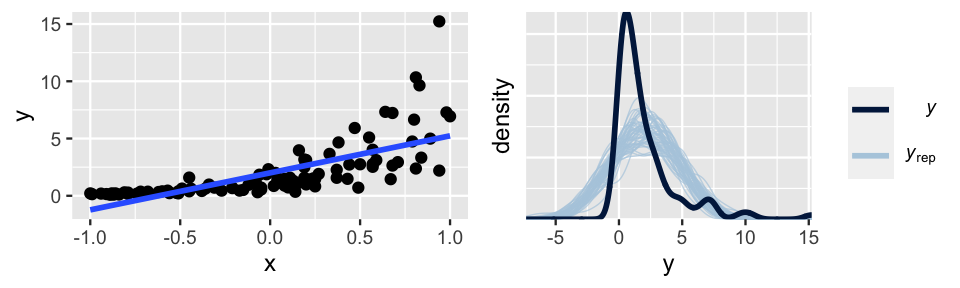

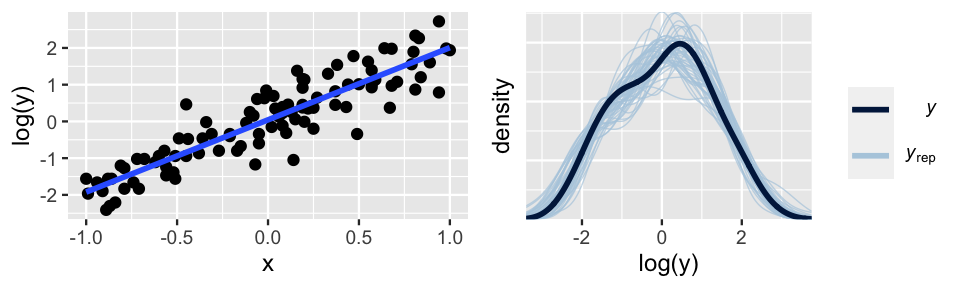

<br>

## 10.03. 모형의 정확성 평가

#### $X=75$인 경우, 실제 관측값은 6228

In [13]:
bikes %>% 
  filter(date == "2012-10-22") %>% 
  select(temp_feel, rides)

temp_feel,rides
<dbl>,<int>
75.46478,6228


#### $X=75$인 경우의 사후예측분포 평균 (예측값) = 3966

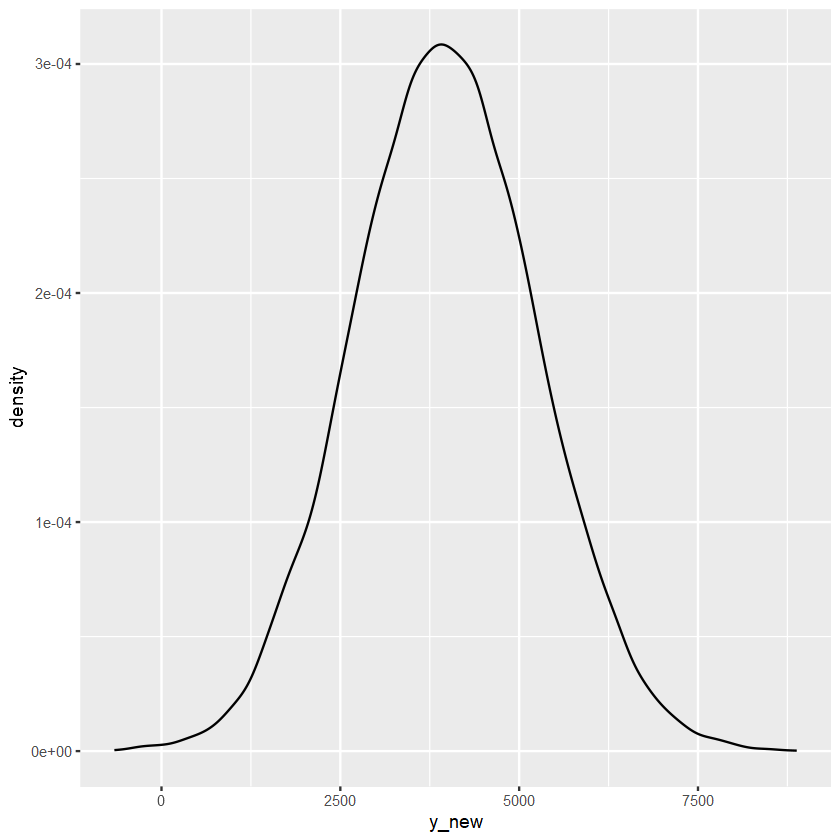

In [16]:
set.seed(84735)
predict_75 <- bike_model_df %>% 
  mutate(mu = `(Intercept)` + temp_feel*75,
         y_new = rnorm(20000, mean = mu, sd = sigma))

ggplot(predict_75, aes(x = y_new)) + 
  geom_density()

In [18]:
predict_75$y_new %>% mean

[1] 3966.3

<br>

### 예측오차 : 실제값과 예측값의 차이 

$$Y - Y'  .$$

<br>

#### 
> $n$개의 관측값 $Y_1, Y_2, \ldots, Y_n$의 각 값 $Y_i$는, 평균을 $Y_i'$ 표준편차를 $\text{sd}_i$로 갖는 사후예측분포를 가지며
>
> 각 사후예측분포의 예측 정확도를 평가


> **`MAE`**
> $$\text{MAE} = \text{median}|Y_i - Y_i'|.$$

> **`MAE_Scaled`**
> $$\text{MAE scaled} = \text{median}\frac{|Y_i - Y_i'|}{\text{sd}_i}.$$

> **`within_50`, `within_95`**
> 
>  각 관측값 별 예측분포들 중,
>
> **50%(혹은 95%) 신용구간에 각 관측값이 포함되어있는 예측분포들의 비율**

<br>

#### 각 마르코프 체인 값과, 각 관측값 별 예측값 생성

In [29]:
set.seed(84735)
predictions <- posterior_predict(bike_model, newdata = bikes)

<br>

#### 각 관측값이, 각 관측값 별 예측분포의 몇 분위에 속해있는지에 대한 시각화

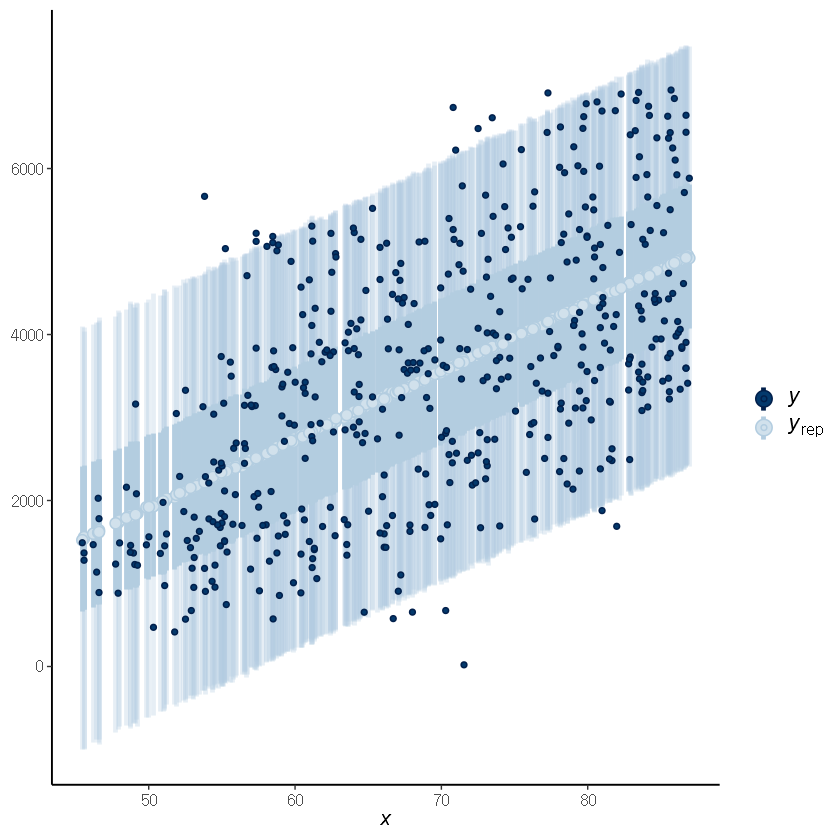

In [30]:
ppc_intervals(bikes$rides, yrep = predictions, x = bikes$temp_feel, 
              prob = 0.5, prob_outer = 0.95)

<br>

#### `prediction_summary(model, data)`

In [27]:
set.seed(84735)
prediction_summary(bike_model, data = bikes)

mae,mae_scaled,within_50,within_95
<dbl>,<dbl>,<dbl>,<dbl>
991.8959,0.7710714,0.438,0.968


<br>

### 교차검증 (Cross-Validation)

<br>

#### K-fold CV
> **fold 생성** : $n$개의 관측값을, 겹치지 않고 균일한 크기를 가진 $k$개의 fold로 분할
> 
> **Train and Test** : $k$개의 fold 중, 첫 fold를 제외한 $k-1$개의 fold를 학습하고, 첫 fold를 성능 평가에 활용
>
> **반복** : 모든 fold들이 성능 평가에 활용될 때 까지, Train and Test를 반복
>
> **교차검증 요약** : 생성한 $k$개의 모형과 성능을 평균

> (fold의 개수를 관측치의 크기 $n$만큼 설정할 시 $\rightarrow$ LOOCV)


<br>

#### `prediction_summary_cv(model, data, k)`

- 10개의 fold에 대한 교차검증

In [33]:
set.seed(84735)
cv_procedure <- prediction_summary_cv(model = bike_model, data = bikes, k = 10)

- 각 fold를 평가 데이터로 활용하였을 때의, 평과 결과

In [34]:
cv_procedure$folds

fold,mae,mae_scaled,within_50,within_95
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,990.2560,0.7698615,0.46,0.98
2,966.9762,0.7455495,0.42,1.00
3,951.4017,0.7304958,0.42,0.98
4,1018.0607,0.7912895,0.46,0.98
5,1161.3059,0.9085343,0.36,0.96
6,937.2161,0.7320193,0.46,0.94
7,1270.1640,1.0058635,0.32,0.96
8,1111.9435,0.8605897,0.36,1.00
9,1099.6436,0.8685897,0.40,0.92


- 각 fold별 평과결과의 평균

In [35]:
cv_procedure$cv

mae,mae_scaled,within_50,within_95
<dbl>,<dbl>,<dbl>,<dbl>
1029.358,0.8019546,0.422,0.966


<br>

#### 일반 평가결과와의 비교
- **일반 평가보다, 교차검증을 통해 나온 평가결과를 활용하는 것이 지향됨**

In [37]:
set.seed(84735)
prediction_summary(bike_model, data = bikes)

mae,mae_scaled,within_50,within_95
<dbl>,<dbl>,<dbl>,<dbl>
991.8959,0.7710714,0.438,0.968


<br>

### 기대 로그예측밀도 (ELPD)
> ELPD는 가능한 모든 새로운 데이터 포인트 $y_new$에 걸쳐, 로그 사후예측분포 pdf인 $\log(f(y_{\text{new}} | \vec{y}))$의 평균을 측정
>
> ELPD가 높을수록 새로운 데이터 포인트를 예측하는데, 사용할 사후예측분포의 정확도가 높다는 것을 의미
>
>  (ELPD를 해석하는 일반적인 척도는 없으며, 일부 경우에서 특정 ELPD는 좋을 수도 있고 다른 경우에서는 나쁠 수도 있음.)

<br>

#### `loo(model)` : 특정 모형의 ELPD를 추정하기 위해,  LOOCV를 진행

In [38]:
model_elpd <- loo(bike_model)
model_elpd$estimates

,Estimate,SE
elpd_loo,-4288.998197,13.1166003
p_loo,2.466119,0.1620926
looic,8577.996395,26.2332007
